# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Цель:

**Построить несколько моделей для предсказания цены поддерженного автомобиля, затем выбрать лучшую.**

## Подготовка данных

In [88]:
#загрузим нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import phik
from sklearn.metrics import make_scorer
warnings.filterwarnings('ignore')

In [89]:
#проведем первичный анализ датасета
data = pd.read_csv("/datasets/autos.csv")

In [90]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [92]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [93]:
#data.phik_matrix(interval_cols=['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode'])

In [94]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


**В данных есть много пропусков, похоже на то, что при выгрузке данных что-то пошло не так.**

In [95]:
#удалим столбцы без особой смысловой нагрузки
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

In [96]:
#для удобства приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354369 non-null  int64 
 1   vehicletype       316879 non-null  object
 2   registrationyear  354369 non-null  int64 
 3   gearbox           334536 non-null  object
 4   power             354369 non-null  int64 
 5   model             334664 non-null  object
 6   kilometer         354369 non-null  int64 
 7   fueltype          321474 non-null  object
 8   brand             354369 non-null  object
 9   repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [98]:
data.describe()

,price,registrationyear,power,kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [99]:
#проверим целевой признак на наличие пропусков
data['price'].isna().sum()

0

### Проанализируем столбцы с аномальными данными

<Axes: ylabel='Frequency'>

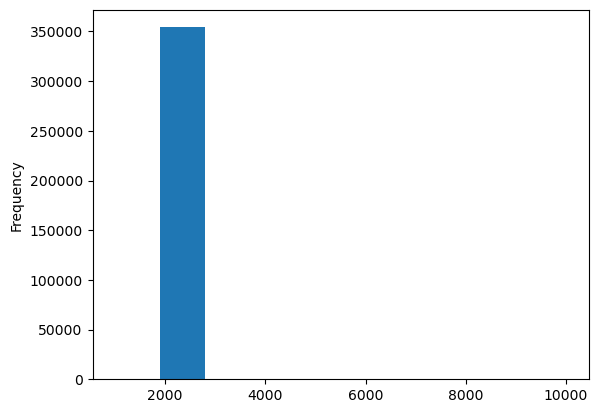

In [100]:
#посмотрим на год регистрации автомобилей
data['registrationyear'].plot(kind='hist')

<Axes: xlabel='registrationyear', ylabel='Count'>

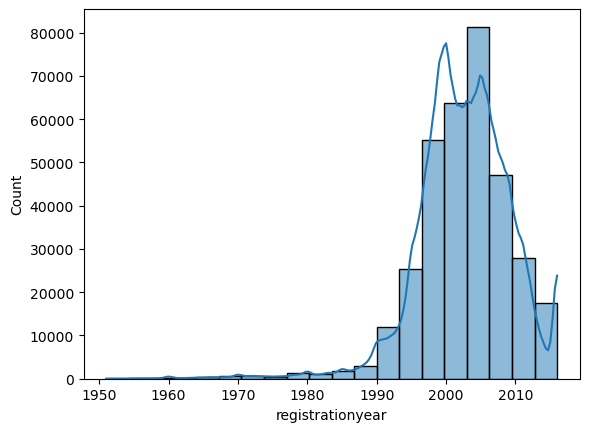

In [101]:
data_n = data.query('1950 < registrationyear < 2017')
sns.histplot(data_n['registrationyear'],bins=20, kde=True)

**Мной был выбран оптимальный промежуток с 1950 по 2023 год**

<Axes: xlabel='price', ylabel='Count'>

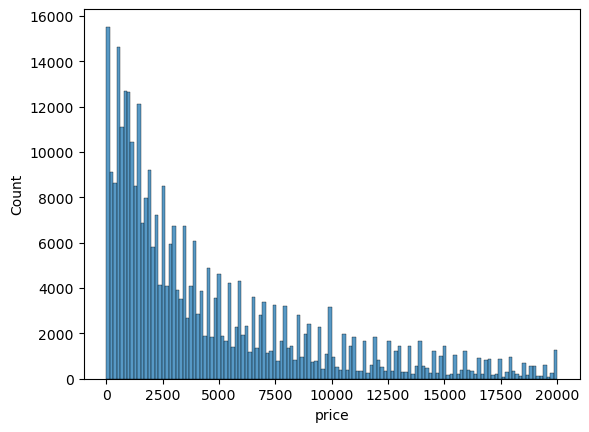

In [102]:
#посмторми на распределение цены
sns.histplot(data_n['price'])

<Axes: xlabel='price', ylabel='Count'>

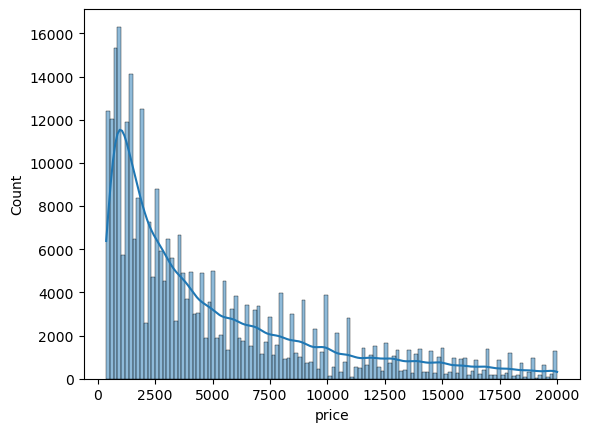

In [103]:
data_n = data_n.query('361 < price')
sns.histplot(data_n['price'], kde=True)

**Цены 0 за машину быть не может, поэтому я взял минимальную цену в 361 евро (~30 000 руб)**

<Axes: xlabel='power', ylabel='Count'>

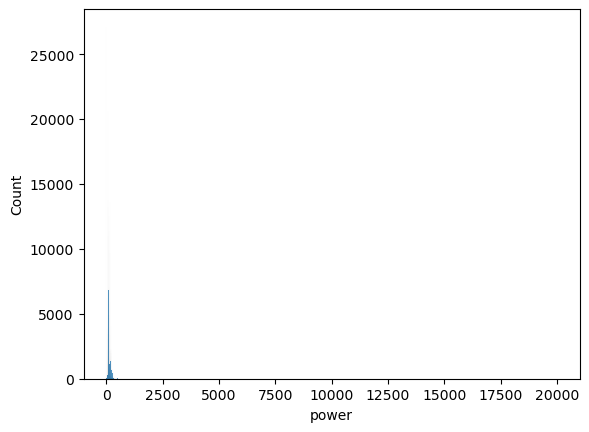

In [104]:
#посмотрим на распределение мощности 
sns.histplot(data_n['power'])

<Axes: xlabel='power', ylabel='Count'>

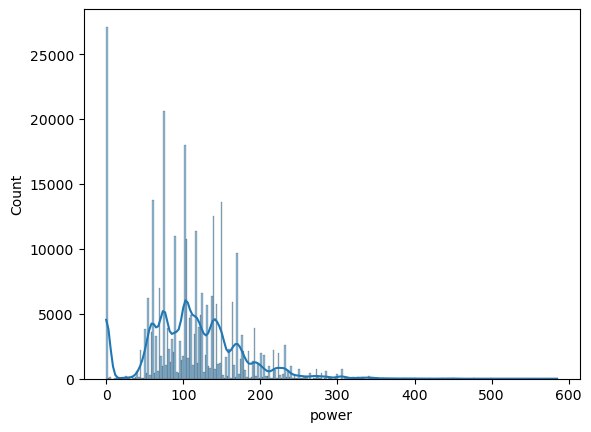

In [105]:
data_n = data_n.query('power < 600')
sns.histplot(data_n['power'], kde=True)

**Максимальной 'силой' было выбранно ограничение в 600 л.с**

In [106]:
#заменим все отсутствующие значения на 0
data_n['power'] = data_n['power'].replace(np.nan, 0)
data_n['vehicletype'] = data_n['vehicletype'].replace(np.nan, 0)

In [107]:
#построим сводную таблицу
v_type = data_n.pivot_table(index=data_n['vehicletype'], aggfunc='median')
print(v_type)

             kilometer  power  price  registrationyear
vehicletype                                           
0               150000     65   1450              2010
bus             150000    110   4400              2005
convertible     150000    125   5599              2003
coupe           150000    150   4400              2001
other           150000     90   2700              2001
sedan           150000    118   3250              2002
small           150000     65   1800              2002
suv             150000    150   8700              2006
wagon           150000    132   3500              2004


In [108]:
mod = data_n.pivot_table(index='model', columns=['vehicletype'], aggfunc='count')['price']

In [109]:
mod.loc['golf'].idxmax()

'sedan'

In [110]:
#заменим все пропуски на 'популярное' значение по группе
for i in mod.index:
    data_n.loc[data_n['model']==i, 'vehicletype'] = data_n.loc[data_n['model']==i, 'vehicletype'].replace(0, mod.loc[i].idxmax())

In [111]:
#заменим все 0 на медианное значение по группе
for i in v_type.index:
    data_n.loc[data_n['vehicletype']==i, 'power'] = data_n.loc[data_n['vehicletype']==i, 'power'].replace(0, v_type.loc[i, 'power'])

In [112]:
#создадим сводную таблицу
br = data_n.pivot_table(index='brand', columns='model', aggfunc='count')['price']

In [113]:
br.index

Index(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo'],
      dtype='object', name='brand')

In [114]:
br.loc['jeep'].idxmax()

'grand'

In [115]:
#заменим все пропуски на 'популярное' значение по группе
for i in br.index:
    data_n.loc[data_n['brand']==i, 'model'] = data_n.loc[data_n['brand']==i, 'model'].replace(np.nan, br.loc[i].idxmax())

In [116]:
data_n['fueltype'] = data_n['fueltype'].apply(lambda x: 'petrol' if x=='gasoline' else x)

In [117]:
#создадим сводную таблицу
m_fuel = data_n.pivot_table(index='model', columns=['fueltype'], aggfunc='count')['price']

In [118]:
m_fuel.loc['100'].idxmax()

'petrol'

In [119]:
data_n['fueltype'].value_counts()

petrol      286236
lpg           4936
cng            516
hybrid         217
other          126
electric        81
Name: fueltype, dtype: int64

In [120]:
#заменим все пропуски на 'популярное' значение по группе
for i in m_fuel.index:
    data_n.loc[data_n['model']==i, 'fueltype'] = data_n.loc[data_n['model']==i, 'fueltype'].replace(np.nan, m_fuel.loc[i].idxmax())

In [121]:
#заменим пропуски на 'yes'
data_n['repaired'] = data_n['repaired'].fillna('yes')

**Пропуски были заполнены 'yes', так как почти все поддержанные автомобили хотя бы 1 раз ремонтировались.**

In [122]:
data_n

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,sedan,1993,manual,118,golf,150000,petrol,volkswagen,yes
1,18300,coupe,2011,manual,190,a4,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,110,zafira,150000,petrol,opel,no
354365,2200,0,2005,NaN,65,NaN,20000,NaN,sonstige_autos,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,petrol,volkswagen,no


In [123]:
#удалим все остальные пропуски
data_n.dropna(subset=['gearbox', 'model'], inplace=True)

In [124]:
data_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297255 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             297255 non-null  int64 
 1   vehicletype       297255 non-null  object
 2   registrationyear  297255 non-null  int64 
 3   gearbox           297255 non-null  object
 4   power             297255 non-null  int64 
 5   model             297255 non-null  object
 6   kilometer         297255 non-null  int64 
 7   fueltype          297255 non-null  object
 8   brand             297255 non-null  object
 9   repaired          297255 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


In [125]:
data_n.reset_index()

,index,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,0,480,sedan,1993,manual,118,golf,150000,petrol,volkswagen,yes
1,1,18300,coupe,2011,manual,190,a4,125000,petrol,audi,yes
2,2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,yes
3,3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
297250,354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
297251,354363,1150,bus,2000,manual,110,zafira,150000,petrol,opel,no
297252,354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
297253,354367,9200,bus,1996,manual,102,transporter,150000,petrol,volkswagen,no


## Промежуточный вывод:

**В данных содержалось много пропусков, которые были частино заполнены, остальные удалены. Так же в исходном датасете содержались аномальные данные (слишком маленькие или слишком большие) от них так же было решение избавиться. В конечном итоге, датасет готов для обучени моделей.**

## Обучение моделей

In [126]:
#преобразуем категориальные данные
data_n['repaired'] = pd.get_dummies(data_n['repaired'], drop_first=True)
data_n['gearbox'] = pd.get_dummies(data_n['gearbox'], drop_first=True)

In [127]:
data_n

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,sedan,1993,1,118,golf,150000,petrol,volkswagen,1
1,18300,coupe,2011,1,190,a4,125000,petrol,audi,1
2,9800,suv,2004,0,163,grand,125000,petrol,jeep,1
3,1500,small,2001,1,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,1,69,fabia,90000,petrol,skoda,0
...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,1,225,leon,150000,petrol,seat,1
354363,1150,bus,2000,1,110,zafira,150000,petrol,opel,0
354366,1199,convertible,2000,0,101,fortwo,125000,petrol,smart,0
354367,9200,bus,1996,1,102,transporter,150000,petrol,volkswagen,0


**В столбце 'repaired' 1 означает что машина была в ремонте, в столбце 'gearbox' 1 означает механическую коробку передач.**

In [128]:
f_col = ['vehicletype', 'model', 'fueltype', 'brand']

In [129]:
data_n[f_col] = data_n[f_col].astype('str')

In [188]:
data_ohe = data_n.copy()
data_ord = data_n.copy()

In [189]:
feat_ohe = data_ohe.drop(['price'], axis=1)
target_ohe = data_ohe['price']
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(feat_ohe, target_ohe, test_size=0.3, random_state=111)

feat_ord = data_ord.drop(['price'], axis=1)
target_ord = data_ord['price']
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(feat_ord, target_ord, test_size=0.3, random_state=111)

In [190]:
X_train_ord

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
316514,small,2003,1,125,corsa,150000,petrol,opel,1
283683,wagon,2000,1,105,golf,150000,petrol,volkswagen,0
107782,suv,2012,1,150,other,90000,petrol,ford,1
171551,wagon,1996,0,136,omega,150000,petrol,opel,1
301994,wagon,2007,1,218,a6,150000,petrol,audi,0
...,...,...,...,...,...,...,...,...,...
125904,small,2002,1,58,twingo,125000,petrol,renault,0
122012,convertible,2000,1,75,astra,150000,petrol,opel,1
161911,small,2004,1,80,corsa,150000,petrol,opel,1
12193,small,2004,1,60,2_reihe,150000,petrol,peugeot,0


In [191]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(X_train_ohe[f_col])
X_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train_ohe[f_col])
X_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test_ohe[f_col])

In [192]:
scaler = StandardScaler()
scaler.fit(X_train_ohe[['registrationyear', 'kilometer', 'power']])
X_train_ohe[['registrationyear', 'kilometer', 'power']] = scaler.transform(X_train_ohe[['registrationyear', 'kilometer', 'power']])
X_test_ohe[['registrationyear', 'kilometer', 'power']] = scaler.transform(X_test_ohe[['registrationyear', 'kilometer', 'power']])
X_train_ohe = X_train_ohe.drop(f_col, axis=1)
X_test_ohe = X_test_ohe.drop(f_col, axis=1)

In [198]:
encod_ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=300)
encod_ord.fit(X_train_ord[f_col])
X_train_ord[f_col] = encod_ord.transform(X_train_ord[f_col])
X_test_ord[f_col] = encod_ord.transform(X_test_ord[f_col])

In [199]:
scaler = StandardScaler()
scaler.fit(X_train_ord[['registrationyear', 'kilometer', 'power']])
X_train_ord[['registrationyear', 'kilometer', 'power']] = scaler.transform(X_train_ord[['registrationyear', 'kilometer', 'power']])
X_test_ord[['registrationyear', 'kilometer', 'power']] = scaler.transform(X_test_ord[['registrationyear', 'kilometer', 'power']])
X_train_ord = X_train_ord.drop(f_col, axis=1)
X_test_ord = X_test_ord.drop(f_col, axis=1)

In [208]:
X_train_ord

,registrationyear,gearbox,power,kilometer,repaired
316514,0.005877,1,0.067910,0.589058,1
283683,-0.465091,1,-0.313604,0.589058,0
107782,1.418781,1,0.544802,-1.049280,1
171551,-1.093049,0,0.277743,0.589058,1
301994,0.633834,1,1.841949,0.589058,0
...,...,...,...,...,...
125904,-0.151113,1,-1.210161,-0.093583,0
122012,-0.465091,1,-0.885874,0.589058,1
161911,0.162866,1,-0.790496,0.589058,1
12193,0.162866,1,-1.172010,0.589058,0


In [201]:
X_train_ohe

,registrationyear,gearbox,power,kilometer,repaired,vehicletype_bus,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,...,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
316514,0.005877,1,0.067910,0.589058,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283683,-0.465091,1,-0.313604,0.589058,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
107782,1.418781,1,0.544802,-1.049280,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171551,-1.093049,0,0.277743,0.589058,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301994,0.633834,1,1.841949,0.589058,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125904,-0.151113,1,-1.210161,-0.093583,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122012,-0.465091,1,-0.885874,0.589058,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161911,0.162866,1,-0.790496,0.589058,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12193,0.162866,1,-1.172010,0.589058,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
#функция скоринга
def rmse(y_true, pred):
    return mean_squared_error(y_true, pred)**0.5

rmse = make_scorer(rmse)

In [203]:
#создадим функцию для удобства
def mod_result(model, feat, target):
    param = {}
    model_f = model

    random_cv = RandomizedSearchCV(
        model_f, param,
        scoring=rmse,
        cv=3,
        n_jobs=-1,
        random_state=111
    )

    random_cv.fit(feat, target)
    return 'Время обучения: {}s, Время предсказания: {}s, RMSE: {}'.\
format(round(random_cv.cv_results_['mean_fit_time'][0], 4),\
       round(random_cv.cv_results_['mean_score_time'][0], 4),\
       round(random_cv.best_score_, 2))

In [213]:
#lin ohe
mod_result(LinearRegression(), X_train_ohe, y_train_ohe)

'Время обучения: 10.6491s, Время предсказания: 1.4074s, RMSE: 2643.16'

In [205]:
#lin ord
mod_result(LinearRegression(), X_train_ord, y_train_ord)

'Время обучения: 0.1559s, Время предсказания: 0.0079s, RMSE: 3033.1'

In [206]:
#tree ohe
mod_result(DecisionTreeRegressor(random_state=111), X_train_ohe, y_train_ohe)

'Время обучения: 17.8363s, Время предсказания: 0.472s, RMSE: 1947.12'

In [207]:
#tree ord
mod_result(DecisionTreeRegressor(random_state=111), X_train_ord, y_train_ord)

'Время обучения: 0.481s, Время предсказания: 0.0283s, RMSE: 2216.66'

In [209]:
#cat ohe
mod_result(CatBoostRegressor(random_state=111, verbose=0), X_train_ohe, y_train_ohe)

'Время обучения: 49.6568s, Время предсказания: 0.5923s, RMSE: 1616.17'

In [210]:
#cat ord
mod_result(CatBoostRegressor(random_state=111, verbose=0), X_train_ord, y_train_ord)

'Время обучения: 39.336s, Время предсказания: 0.0571s, RMSE: 1992.55'

In [211]:
#lgb ord
mod_result(lgb.LGBMRegressor(random_state=111), X_train_ohe, y_train_ohe)

'Время обучения: 6.888s, Время предсказания: 1.7238s, RMSE: 1693.81'

In [212]:
#lgb ohe
mod_result(lgb.LGBMRegressor(random_state=111), X_train_ord, y_train_ord)

'Время обучения: 1.3438s, Время предсказания: 0.654s, RMSE: 2020.91'

## Анализ моделей

In [214]:
#создадим дадафрейм с результатами
df = pd.DataFrame({'RMSE':[2643, 3033, 1947, 2216, 1616, 1992, 1693, 2020],\
                   'Learning_time_s':[10.6491,0.1559, 17.8363,0.481,49.6568,39.336, 6.888,1.3438],
                  'Predict_time_s':[0.1559, 0.0079, 0.472, 0.0283, 0.5923, 0.0571, 1.7238, 0.654]},\
                  index=['LinearReg_ohe', 'LinearReg_ord', 'Tree_ohe', 'Tree_ord',\
                         'Catboost_ohe', 'Catboost_ord', 'LGB_ohe', 'LGB_ord'])

In [215]:
#вычислим общий рейтинг, чем меньше тем лучше 
#(4000, 100 сек и 5 сек были взяты из расчета максимально возможной величины по столбику)
df['Overall_score'] = (df['RMSE']/4000) + (df['Learning_time_s']/100) + (df['Predict_time_s']/5)

In [216]:
df

,RMSE,Learning_time_s,Predict_time_s,Overall_score
LinearReg_ohe,2643,10.6491,0.1559,0.798421
LinearReg_ord,3033,0.1559,0.0079,0.761389
Tree_ohe,1947,17.8363,0.4720,0.759513
Tree_ord,2216,0.4810,0.0283,0.564470
Catboost_ohe,1616,49.6568,0.5923,1.019028
Catboost_ord,1992,39.3360,0.0571,0.902780
LGB_ohe,1693,6.8880,1.7238,0.836890
LGB_ord,2020,1.3438,0.6540,0.649238


## Вывод:

**Лучшей моделью оказалась модель решающего дерева, но мы возьмем lightLGB, потому что время обучения и предсказания близки, а RMSE лучше. Модель решающего дерева можно использовать если нужна скорость обучения, а score на 2 плане. Лучший score у модели Catboost, но время обучения довольно таки большое. Модель линейной регрессии ввобще не справилась с задачей.**

**После проверки нескольких моделей, которые обучались на разных закодированных данных. Лучше всего себя показала модель LightLGB с результатом rmse = 1708, которая была обучена на данных, которые были закодированны при помощи OrdinalEncoder.**

In [229]:
param = {}
model_lgb = lgb.LGBMRegressor(n_estimators=400, max_depth=20, num_leaves=65, learning_rate=0.15 ,random_state=111)

model_lgb.fit(X_train_ord, y_train_ord)
pred = model_lgb.predict(X_test_ord)
print(mean_squared_error(y_test_ord, pred)**0.5)

1967.536229395808


**Аргументы находил при помощи RandomizedSearchCV**